In [1]:
import torch
from torch.utils.data import DataLoader
import albumentations as A
from datasets import GTA5, CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from models.bisenet.build_bisenet import BiSeNet
from training import train
from model_evaluation import save_results
from visualization import  plot_loss, plot_mIoU, plot_IoU
from config import BATCH_SIZE, NC, NUM_WORKERS, CITYSCAPE_SIZE, GTA5_SIZE, EPOCHS, CITYSCAPES_MEAN, CITYSCAPES_STD, GTA5_MEAN, GTA5_STD
torch.cuda.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:

transforms = A.Compose([
    A.Resize(CITYSCAPE_SIZE[0], CITYSCAPE_SIZE[1]),
])
transforms_GTA5 = A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),


])

cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transforms)
cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transforms)
GTA5_dataset = GTA5('./GTA5', transform=transforms_GTA5)

cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# cityscapes_mean, city_scapes_std = calculate_mean_std(cityscapes_train_dataloader)
# GTA5_mean, GTA5_std = calculate_mean_std(GTA5_dataloader)

len(cityscapes_train_dataloader)

393

## 2.1 DeepLabV2

In [ ]:

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 2.5e-4
model_deeplab = get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='./models/deeplab_resnet_pretrained_imagenet.pth').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_deeplab = torch.nn.DataParallel(model_deeplab).to(device)
optimizer_deeplab = torch.optim.SGD(model_deeplab.parameters(), lr=init_lr, momentum=0.9, weight_decay=5e-4)

deeplab_result = train(model = model_deeplab,
                       optimizer = optimizer_deeplab,
                       loss_fn = loss_fn, 
                       train_dataloader = cityscapes_train_dataloader,
                       validation_dataloader = cityscapes_test_dataloader, 
                       epochs = EPOCHS,
                       device = device,
                       model_name = "deeplab",
                       class_number= NC)

In [ ]:
save_results(model_deeplab, deeplab_result, "deeplab_performance_metrics_2_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_mIoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_IoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")

torch.save(model_deeplab.state_dict(), "./checkpoints/deeplab_model_2_1.pth")

## 2.2 BiseNet


In [4]:
init_lr = 2.5e-2
model_bisenet = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet = torch.nn.DataParallel(model_bisenet).to(device)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet = torch.optim.Adam(model_bisenet.parameters(), lr=init_lr)

bisenet_result_2_2 = train(model = model_bisenet,
                           optimizer = optimizer_bisenet,
                           loss_fn = loss_fn, 
                           train_dataloader = cityscapes_train_dataloader,
                           validation_dataloader = cityscapes_test_dataloader, 
                           epochs = EPOCHS,
                           device = device,
                           model_name = "bisenet",
                           class_number= NC)



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.9444346819215148, Validation Loss: 0.48020977795124054
Train mIoU: 0.2653789039738441, Validation mIoU: 0.2843057152728912
Epoch: 1
Train Loss: 1.1245678306839242, Validation Loss: 0.3482408666610718
Train mIoU: 0.3432959107248519, Validation mIoU: 0.3451175676468959
Epoch: 2
Train Loss: 0.9344583681521524, Validation Loss: 0.41106256723403933
Train mIoU: 0.3830530526413121, Validation mIoU: 0.3250049988289355
Epoch: 3
Train Loss: 0.8091267740150141, Validation Loss: 0.293148736000061
Train mIoU: 0.41765249064153925, Validation mIoU: 0.38879178716182505
Epoch: 4
Train Loss: 0.7354170458614068, Validation Loss: 0.2828645120859146
Train mIoU: 0.43727166110502236, Validation mIoU: 0.4036413717995743
Epoch: 5
Train Loss: 0.688550230276797, Validation Loss: 0.48069718182086946
Train mIoU: 0.45368883354399325, Validation mIoU: 0.3241301210972146
Epoch: 6
Train Loss: 0.6285428872696923, Validation Loss: 0.26701694083213806
Train mIoU: 0.46848392820880913, Validation mIo

KeyboardInterrupt: 

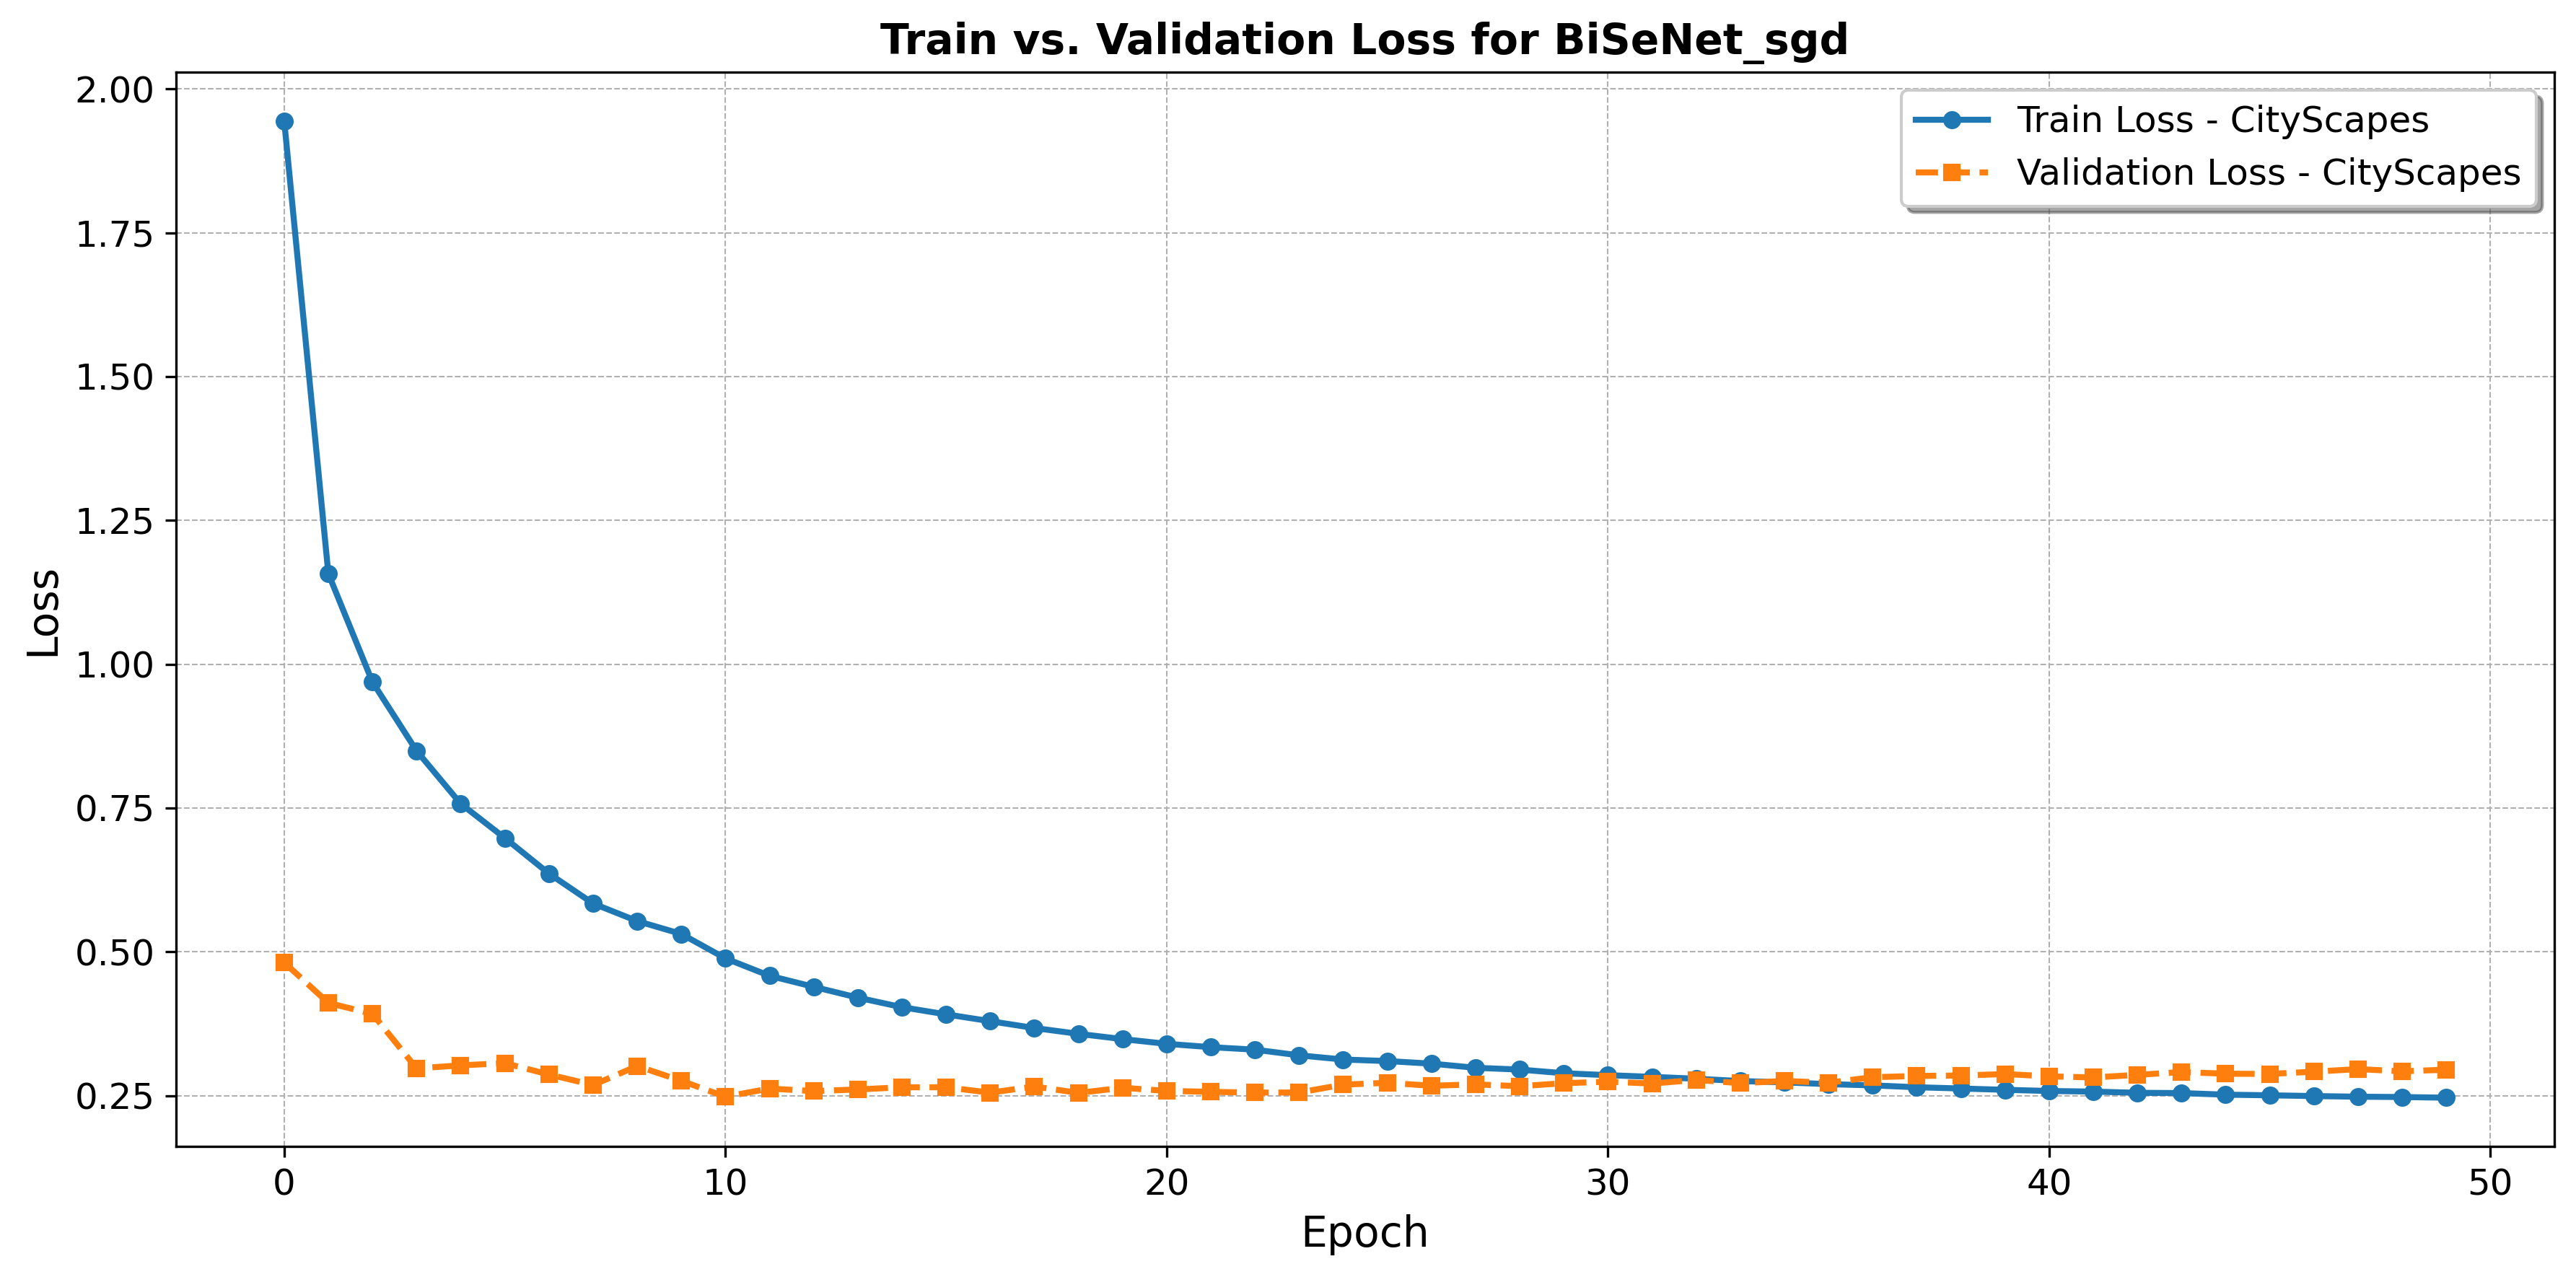

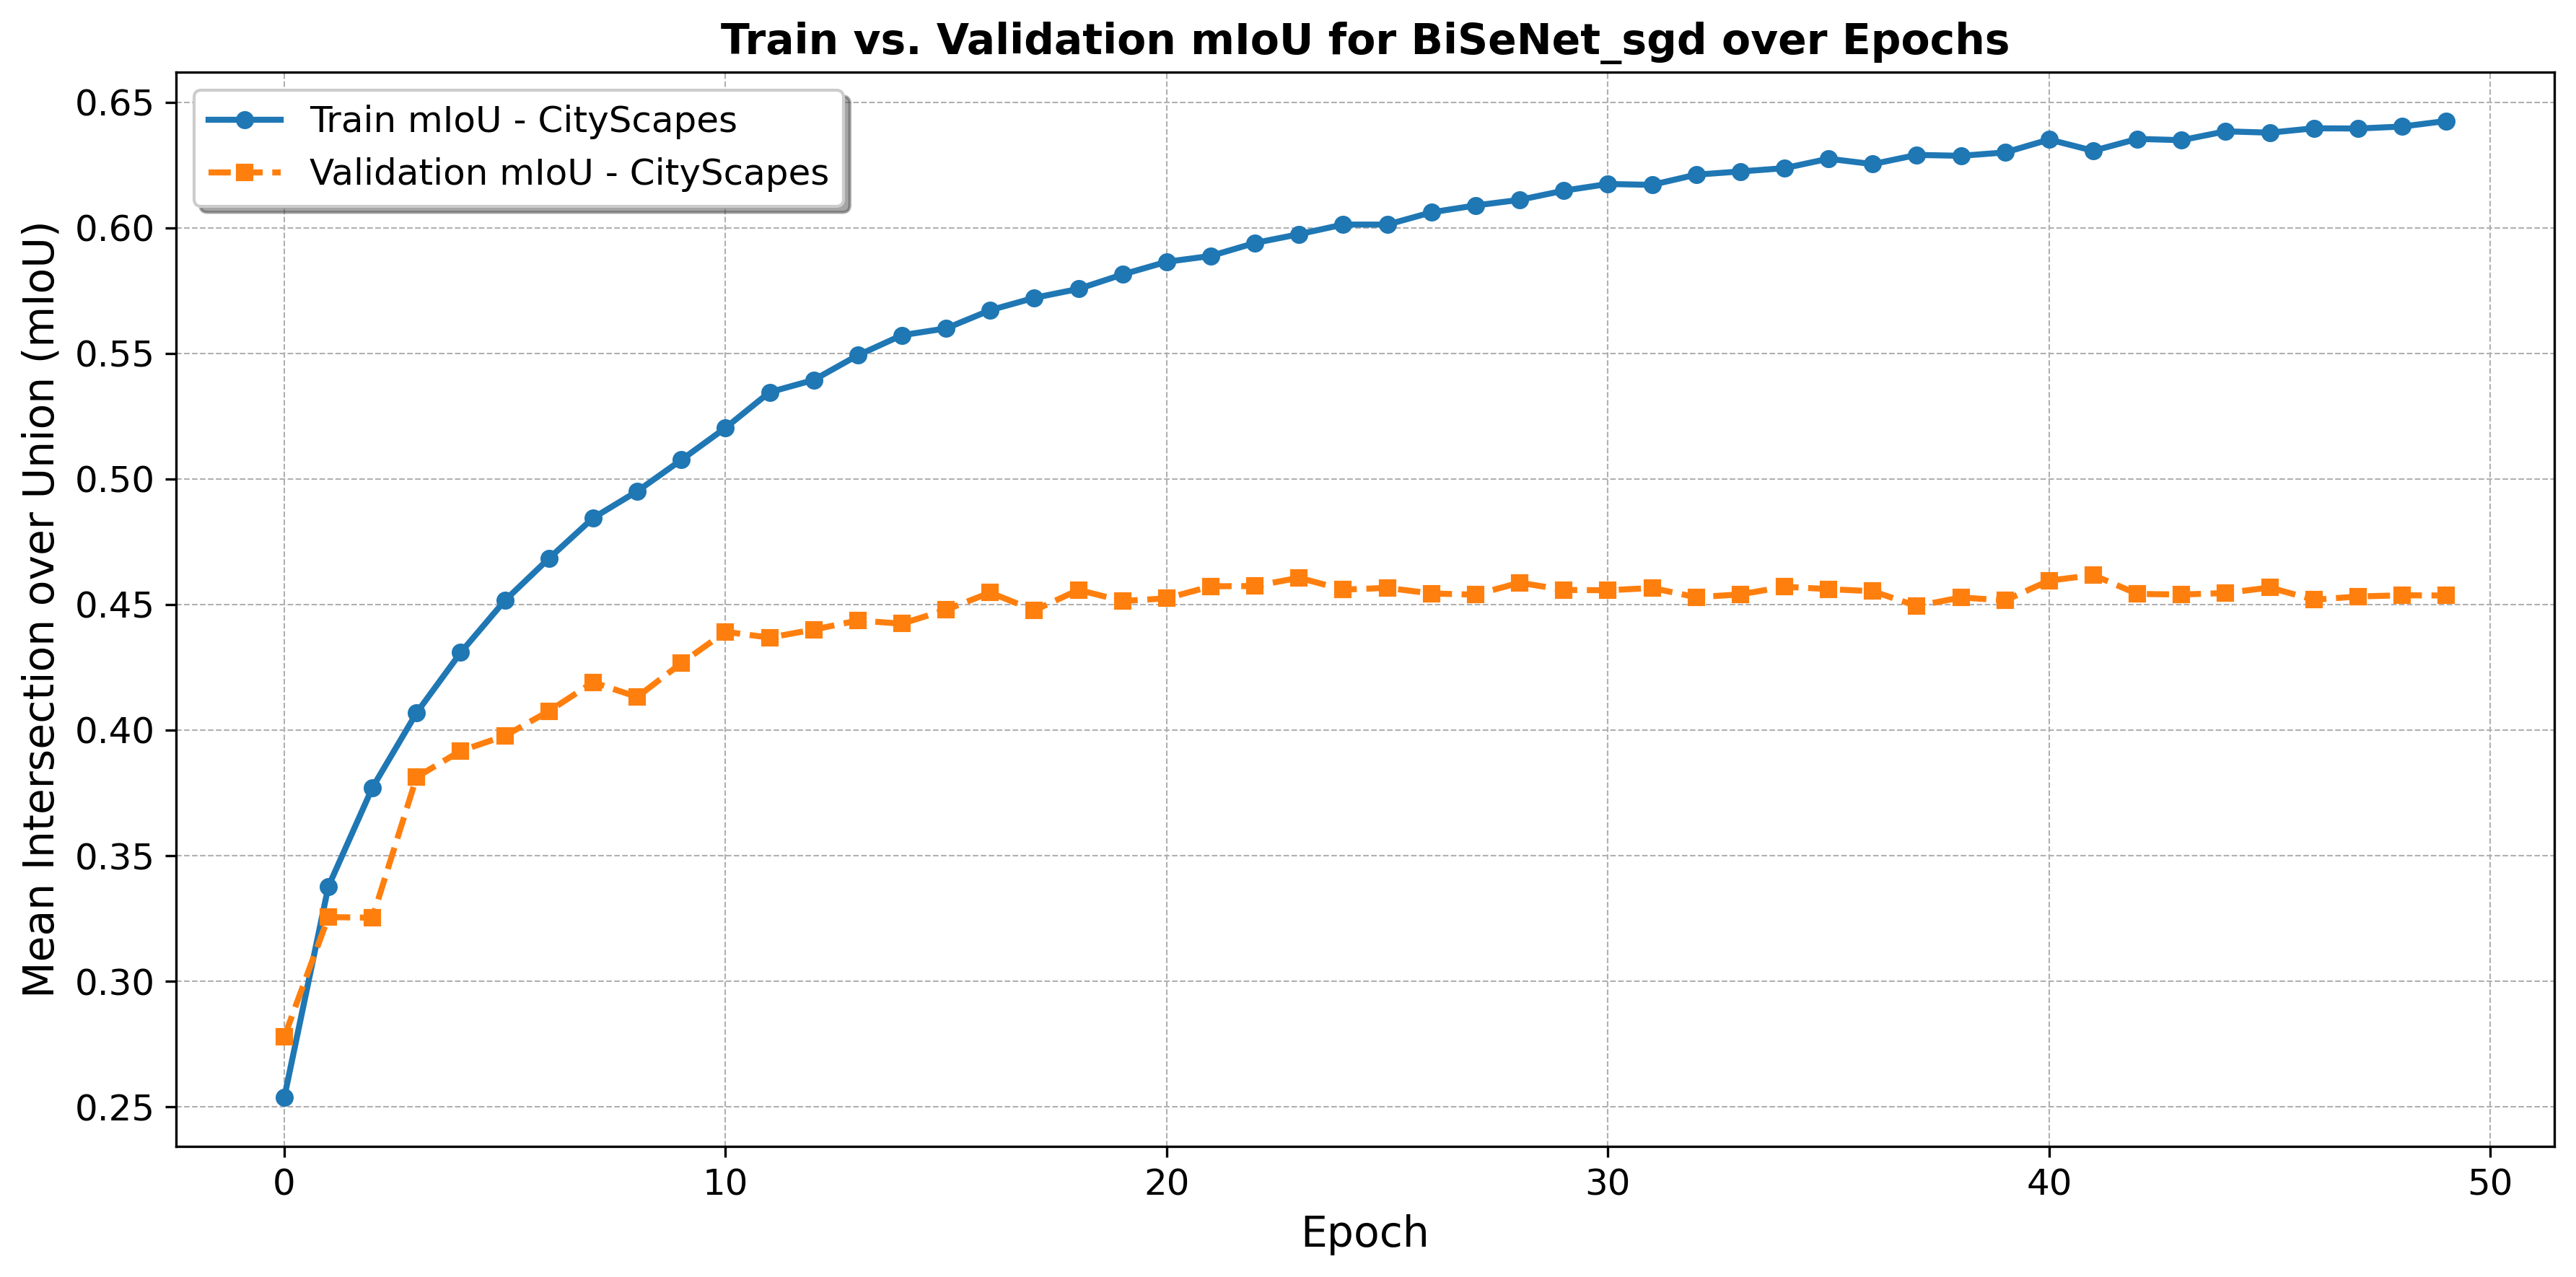

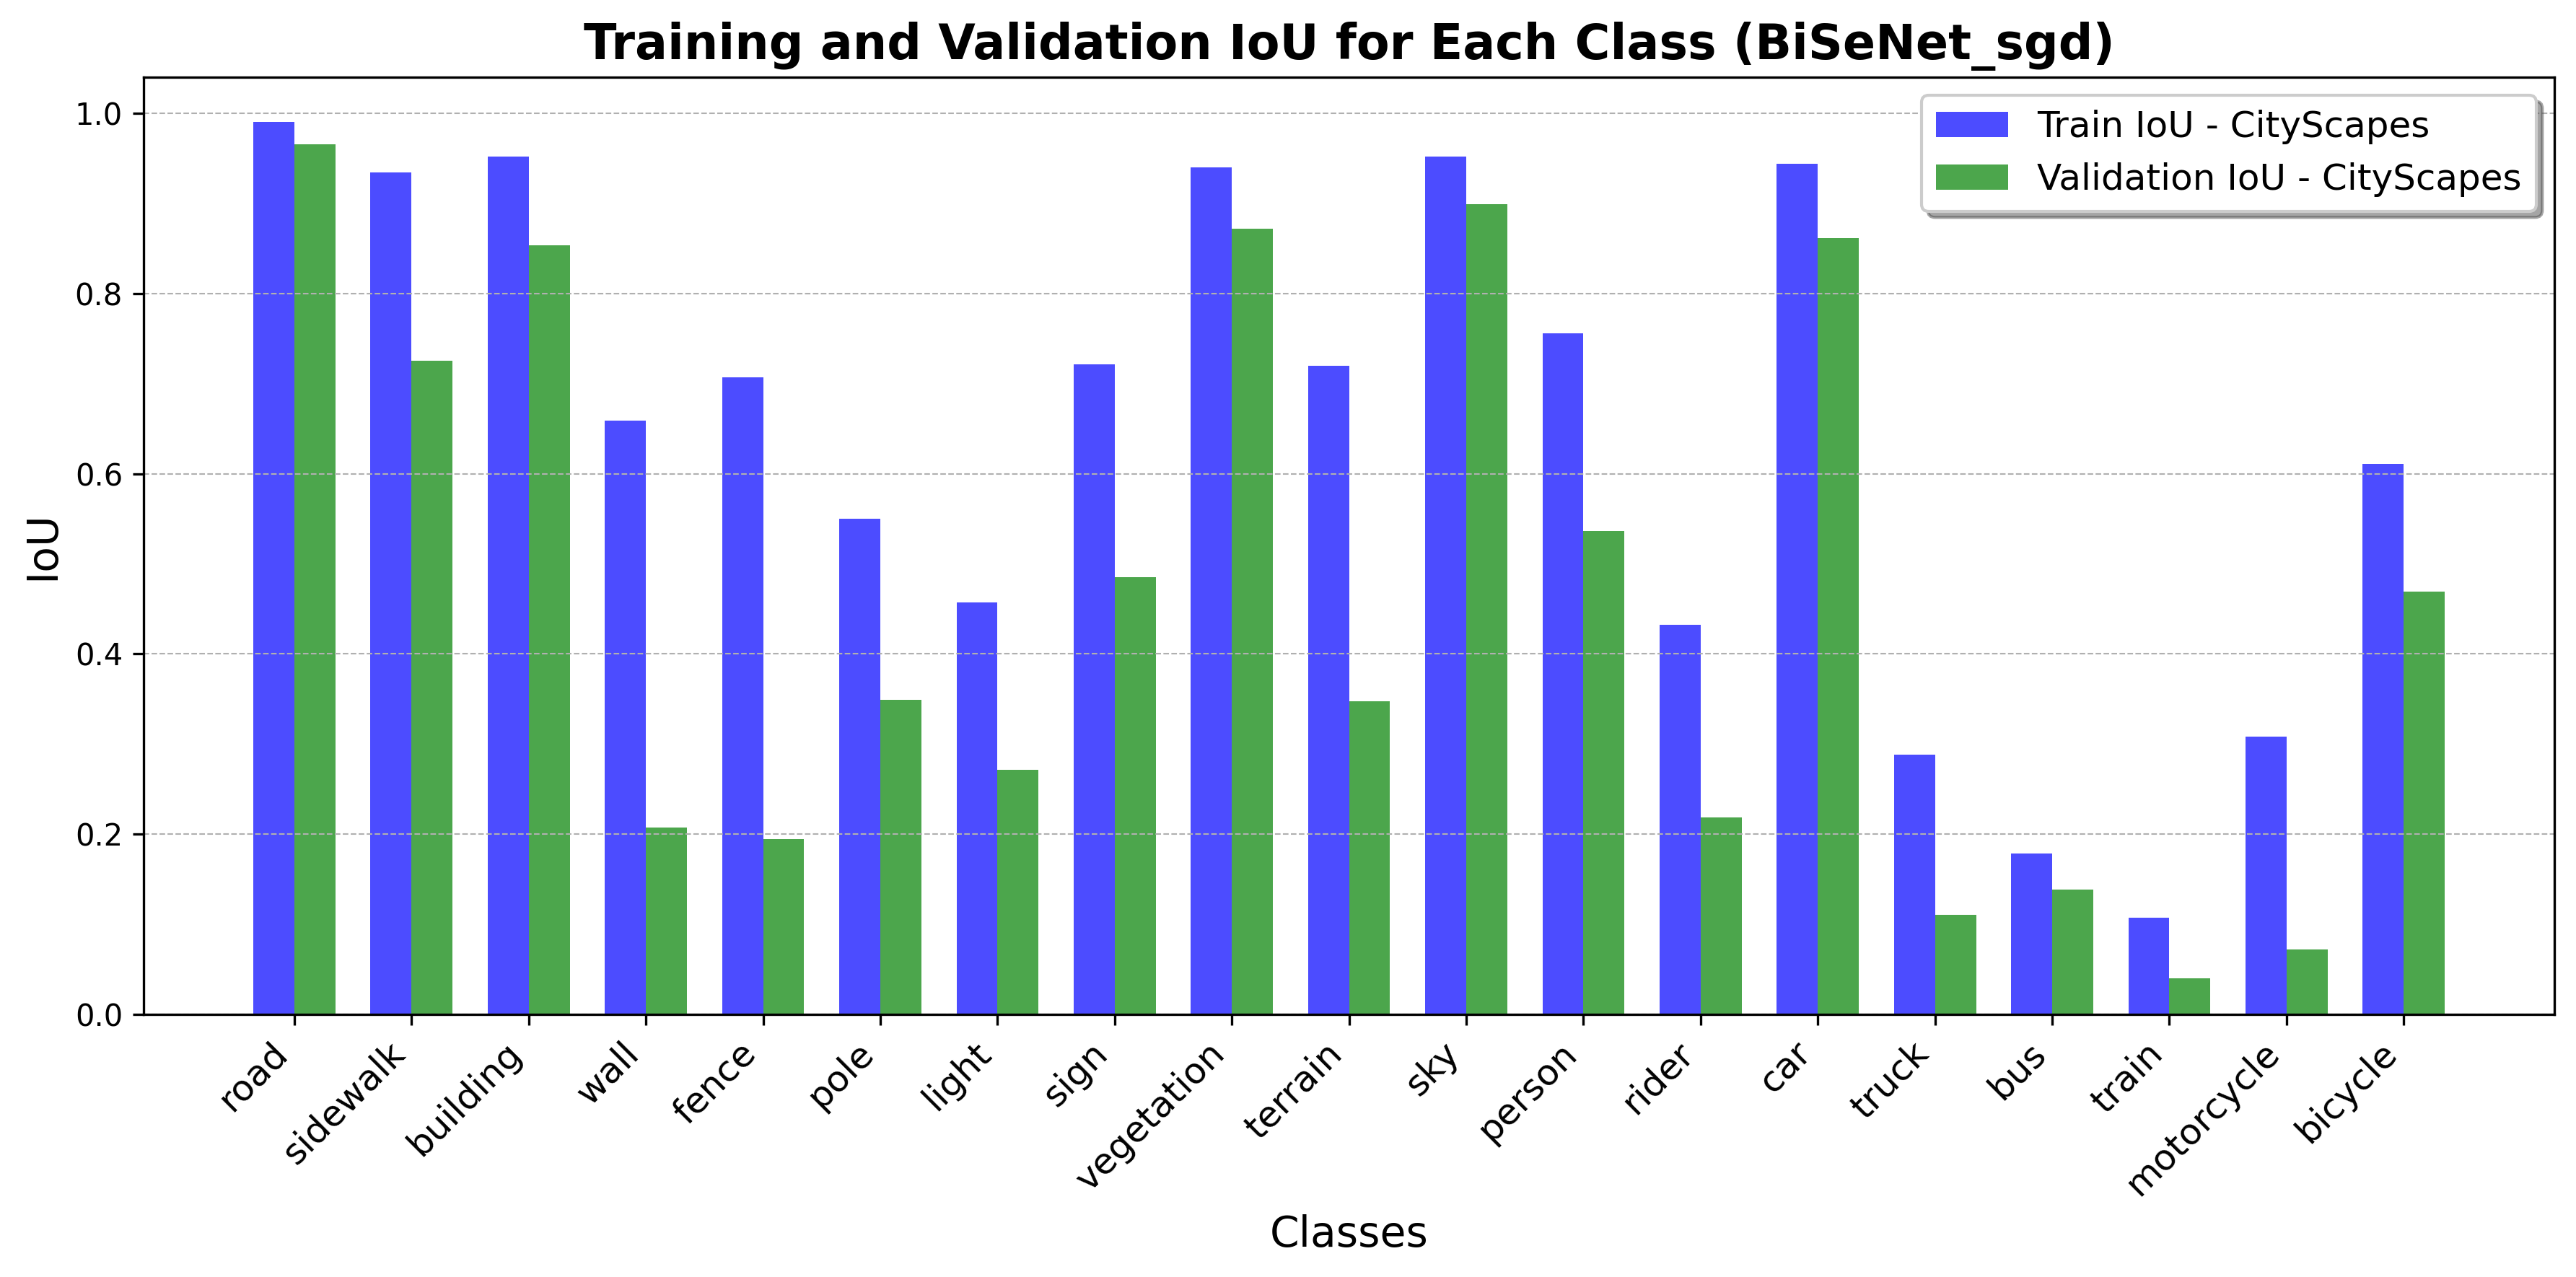

In [4]:

import importlib
import model_evaluation
importlib.reload(model_evaluation)
from model_evaluation import save_results
model_bisenet.eval()
save_results(model_bisenet, bisenet_result_2_2, "bisenet_sgd_performance_metrics_2_2", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100)
plot_loss(bisenet_result_2_2, "BiSeNet_sgd", "step2_2", "CityScapes", "CityScapes")
plot_mIoU(bisenet_result_2_2, "BiSeNet_sgd", "step2_2", "CityScapes", "CityScapes")
plot_IoU(bisenet_result_2_2, "BiSeNet_sgd", "step2_2", "CityScapes", "CityScapes")
torch.save(model_bisenet.state_dict(), "./checkpoints/bisenet_sgd_model_2_2.pth")



## 3.1 Bisenet

In [5]:
model_bisenet_3_1 = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_3_1 = torch.nn.DataParallel(model_bisenet_3_1).to(device)
init_lr = 2.5e-2
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet_3_1 = torch.optim.SGD(model_bisenet_3_1.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
bisenet_result_3_1 = train(model=model_bisenet_3_1,
                           optimizer=optimizer_bisenet_3_1,
                           loss_fn=loss_fn,
                           train_dataloader=GTA5_dataloader,
                           validation_dataloader=cityscapes_test_dataloader,
                           epochs=EPOCHS,
                           device=device,
                           model_name="bisenet",
                           class_number=NC)



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.7557502130508422, Validation Loss: 1.3632406611442567
Train mIoU: 0.2355931359643181, Validation mIoU: 0.13818366276714059
Epoch: 1
Train Loss: 1.097685614013672, Validation Loss: 1.7801770162582398
Train mIoU: 0.30630016157706924, Validation mIoU: 0.11234451979141732
Epoch: 2
Train Loss: 0.9048374710083008, Validation Loss: 1.3967339000701904
Train mIoU: 0.34091737444773296, Validation mIoU: 0.14270992228360407
Epoch: 3
Train Loss: 0.8207857789993286, Validation Loss: 1.7917399730682373
Train mIoU: 0.3666089898513072, Validation mIoU: 0.12714738227030442
Epoch: 4
Train Loss: 0.7349057434082031, Validation Loss: 1.388428686618805
Train mIoU: 0.393325093258781, Validation mIoU: 0.16836584920343656
Epoch: 5
Train Loss: 0.6793524000167847, Validation Loss: 1.9028003196716308
Train mIoU: 0.4137907722397665, Validation mIoU: 0.1363800603782491
Epoch: 6
Train Loss: 0.6339049092769623, Validation Loss: 1.5263196229934692
Train mIoU: 0.43153556467654086, Validation mIoU:

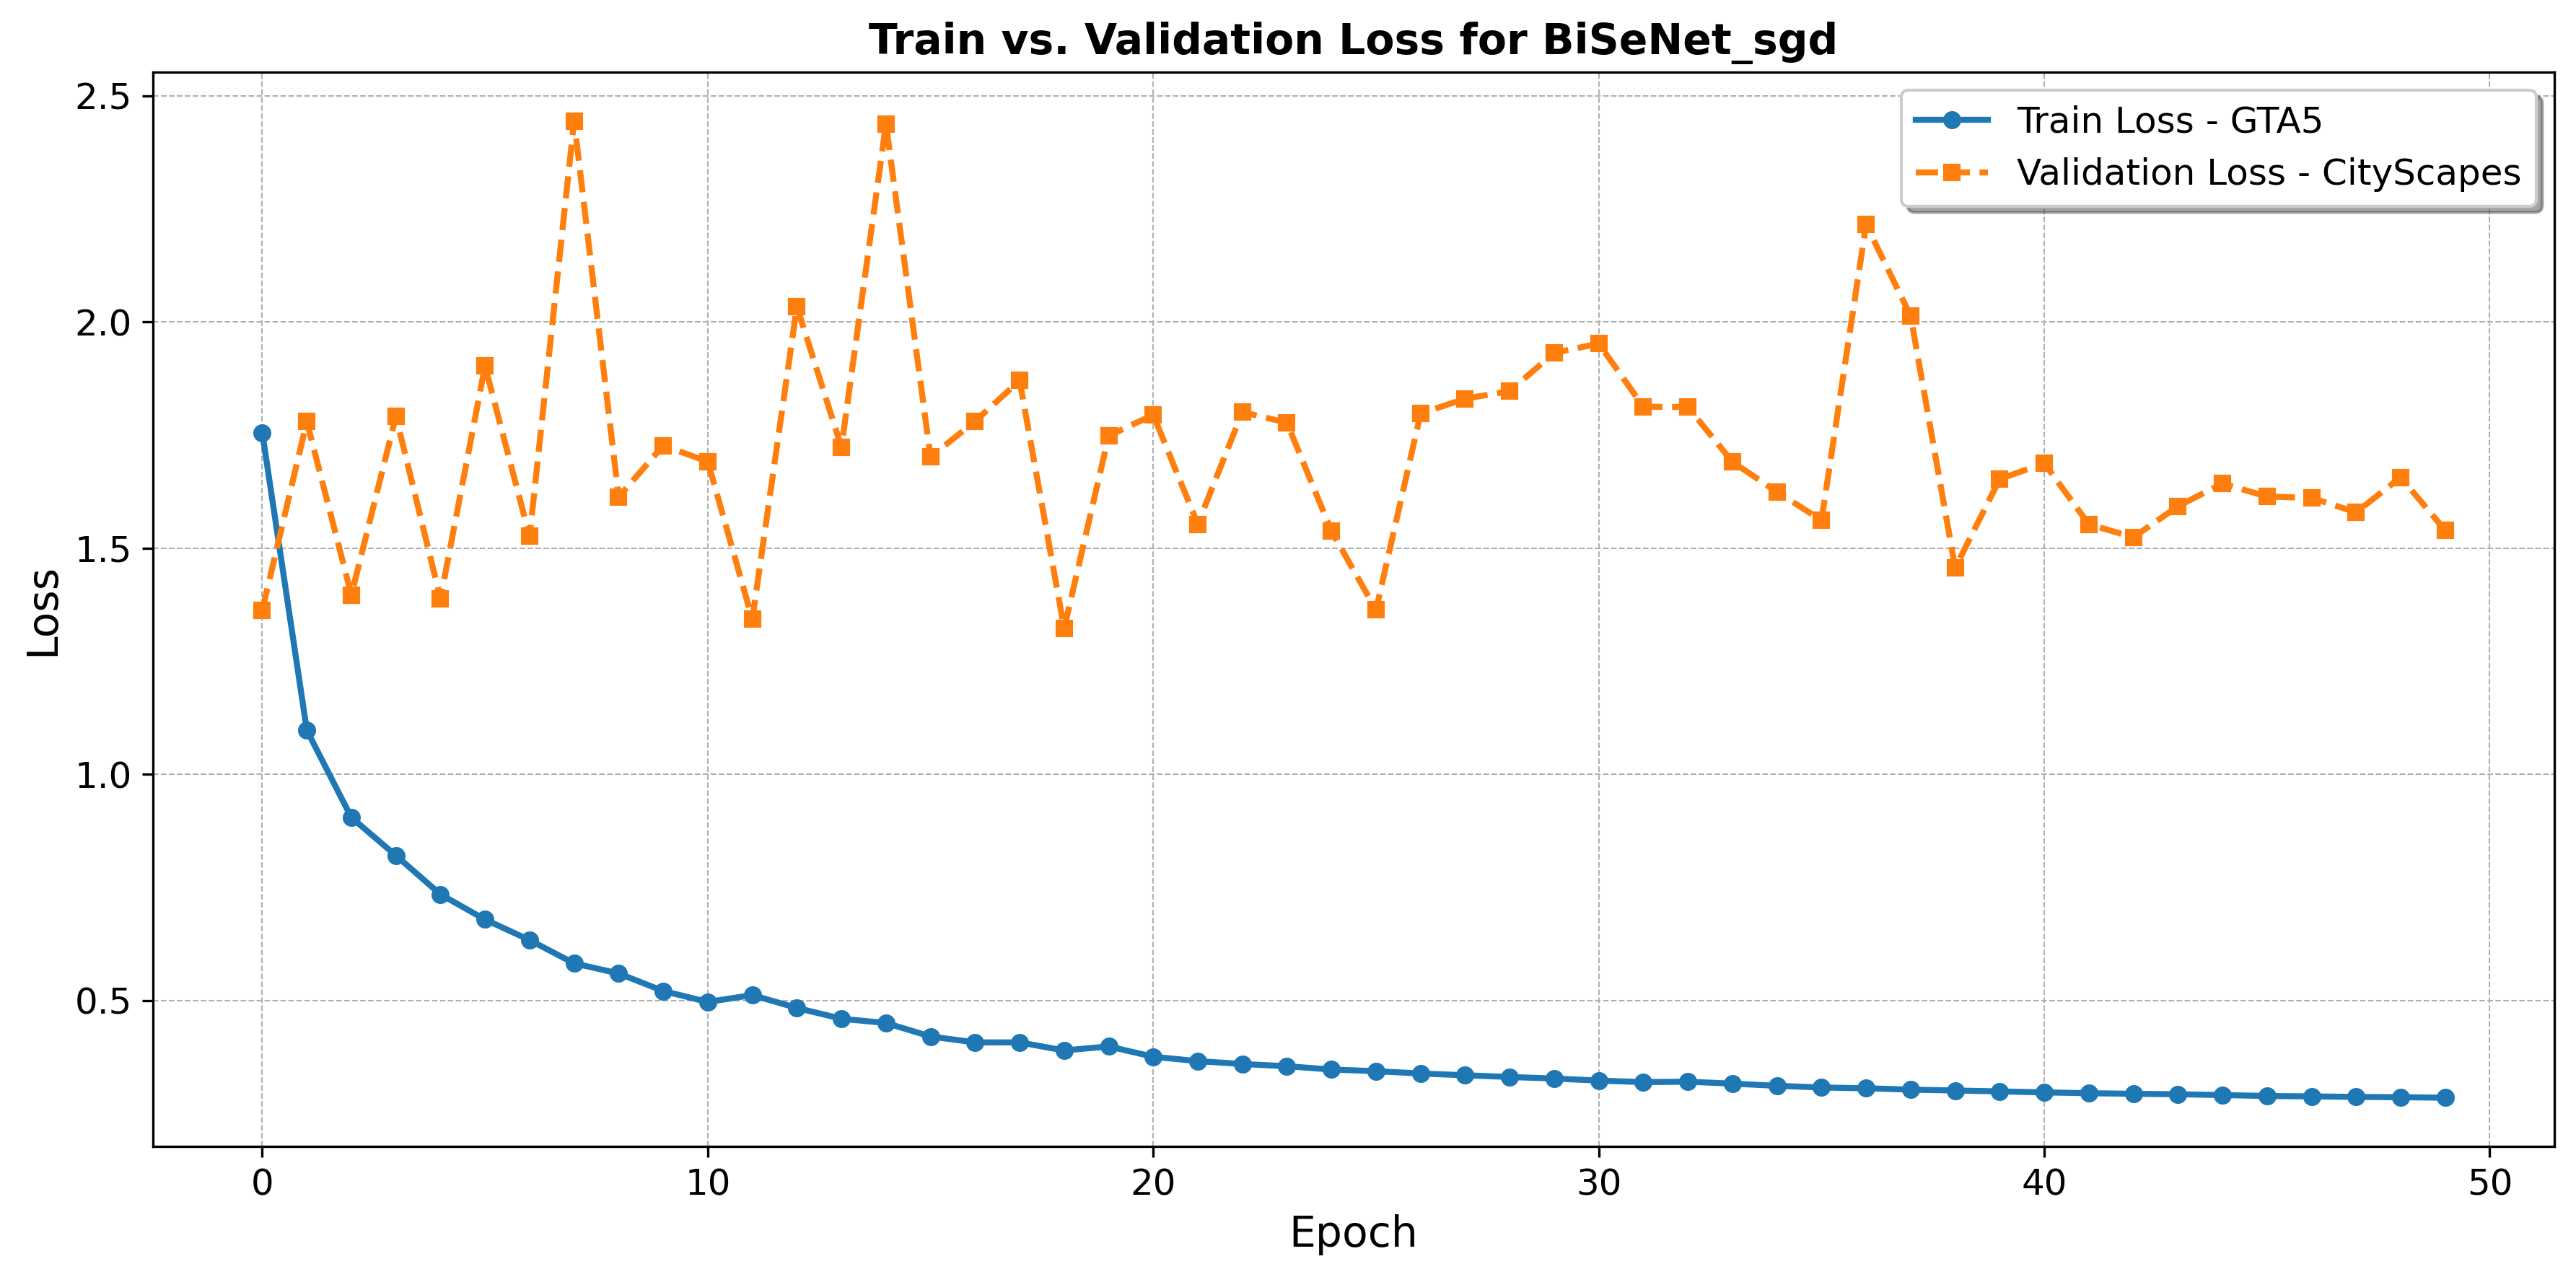

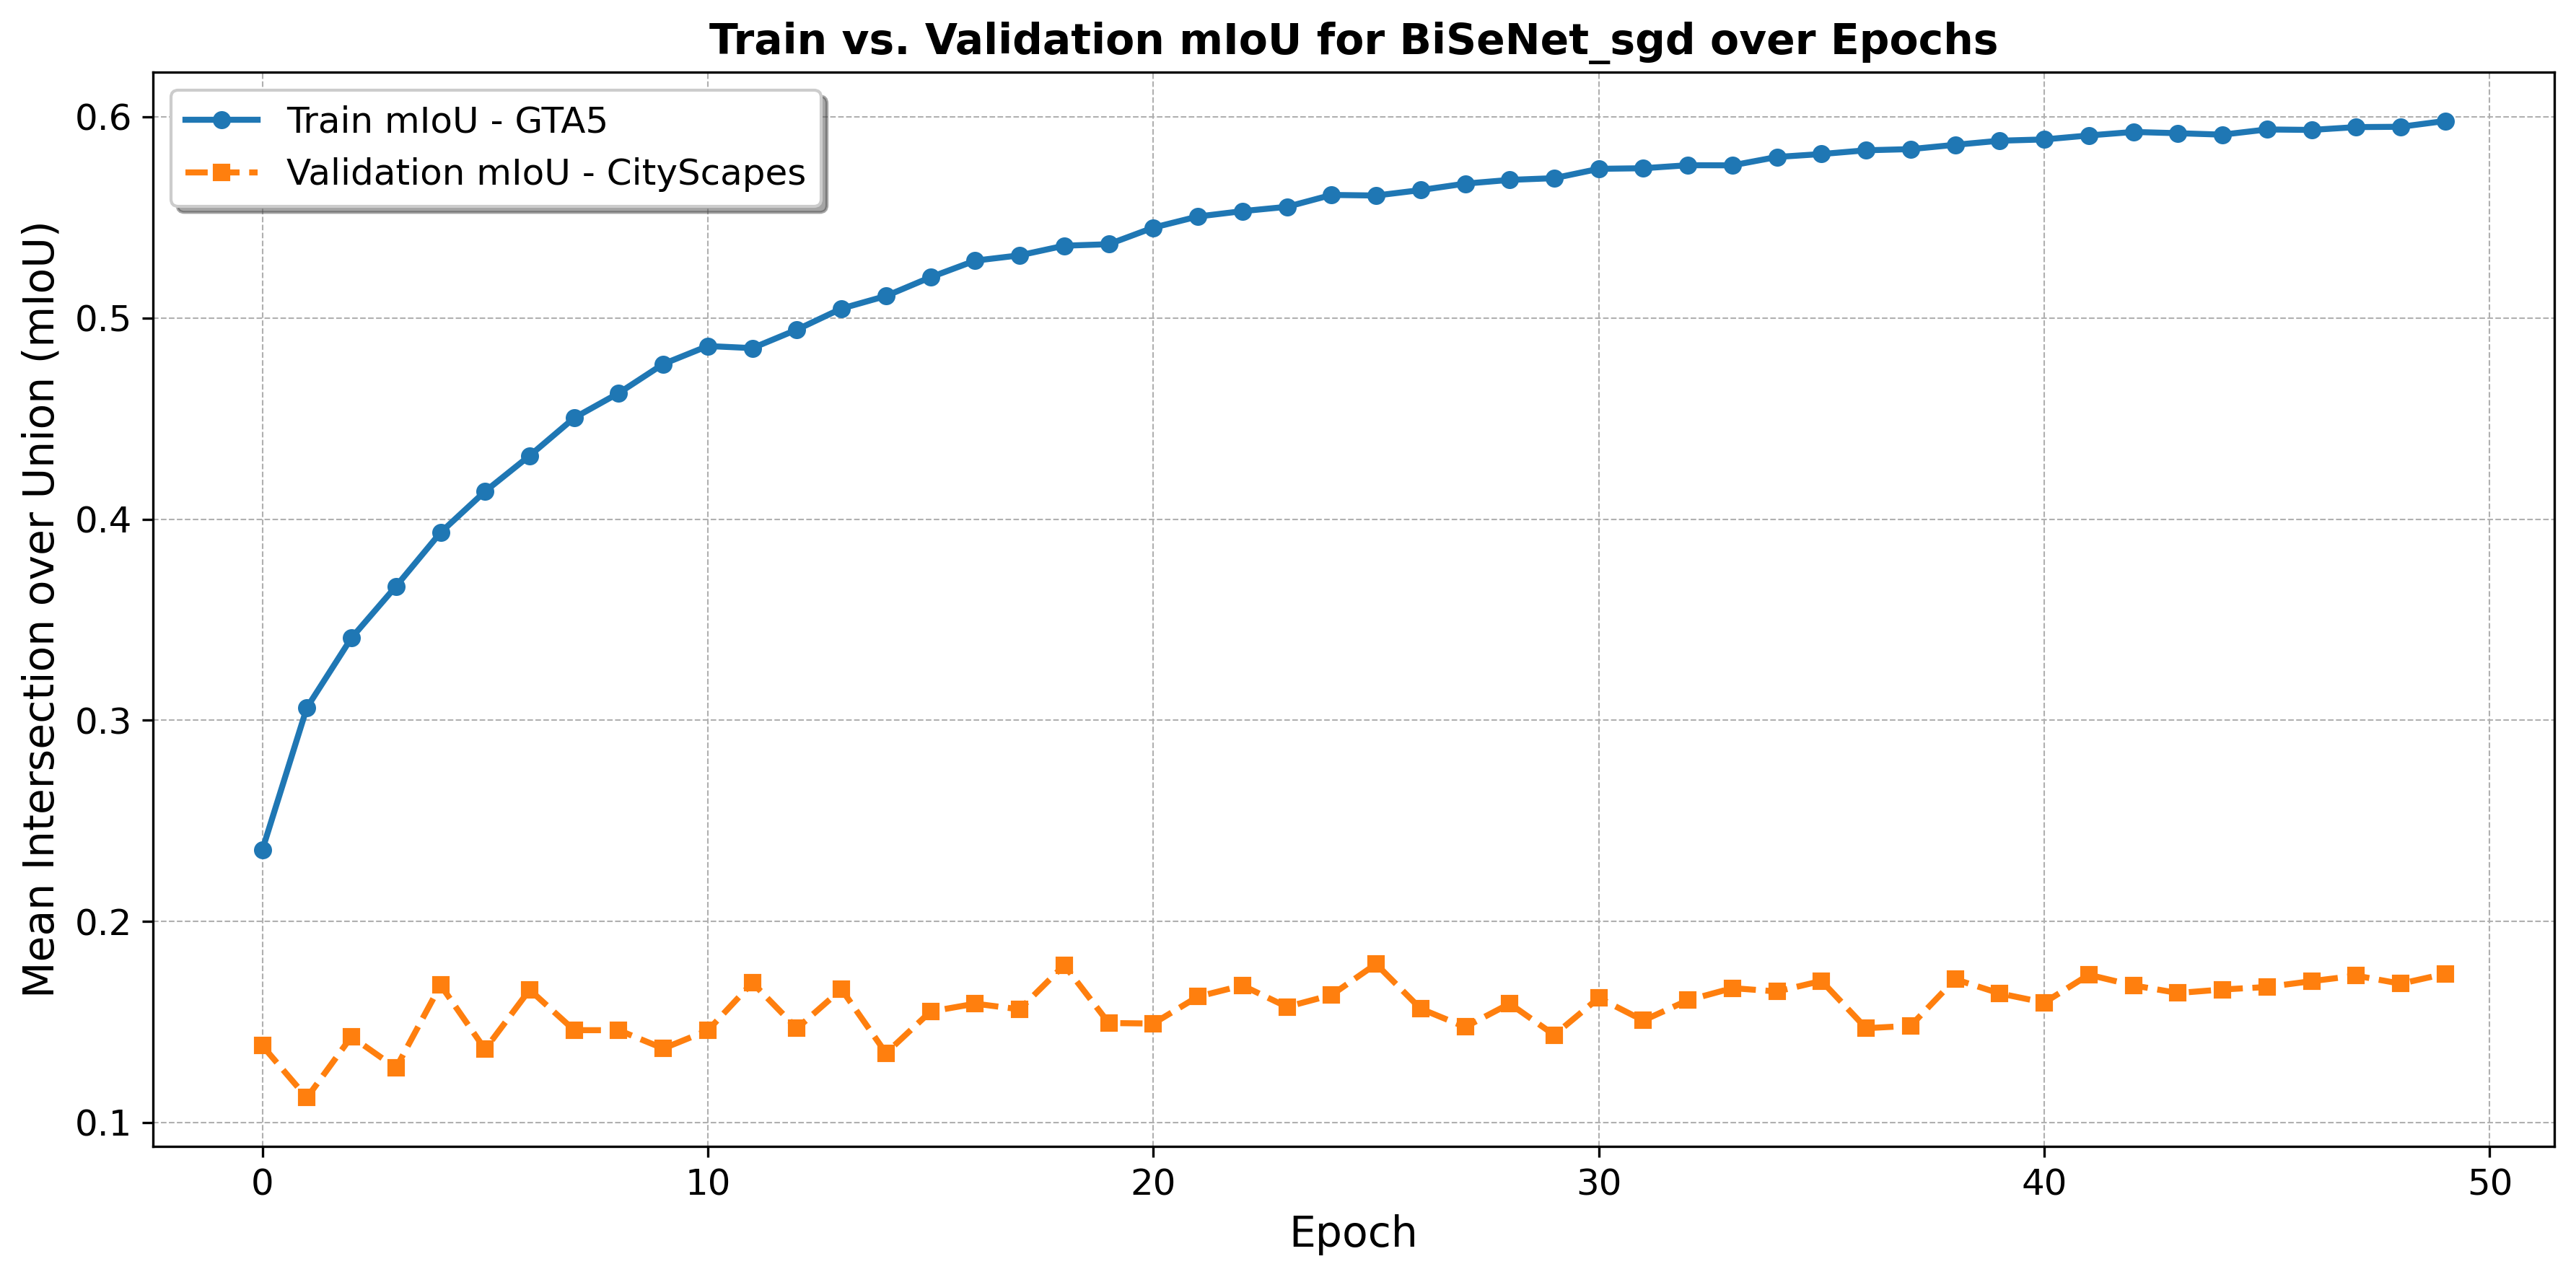

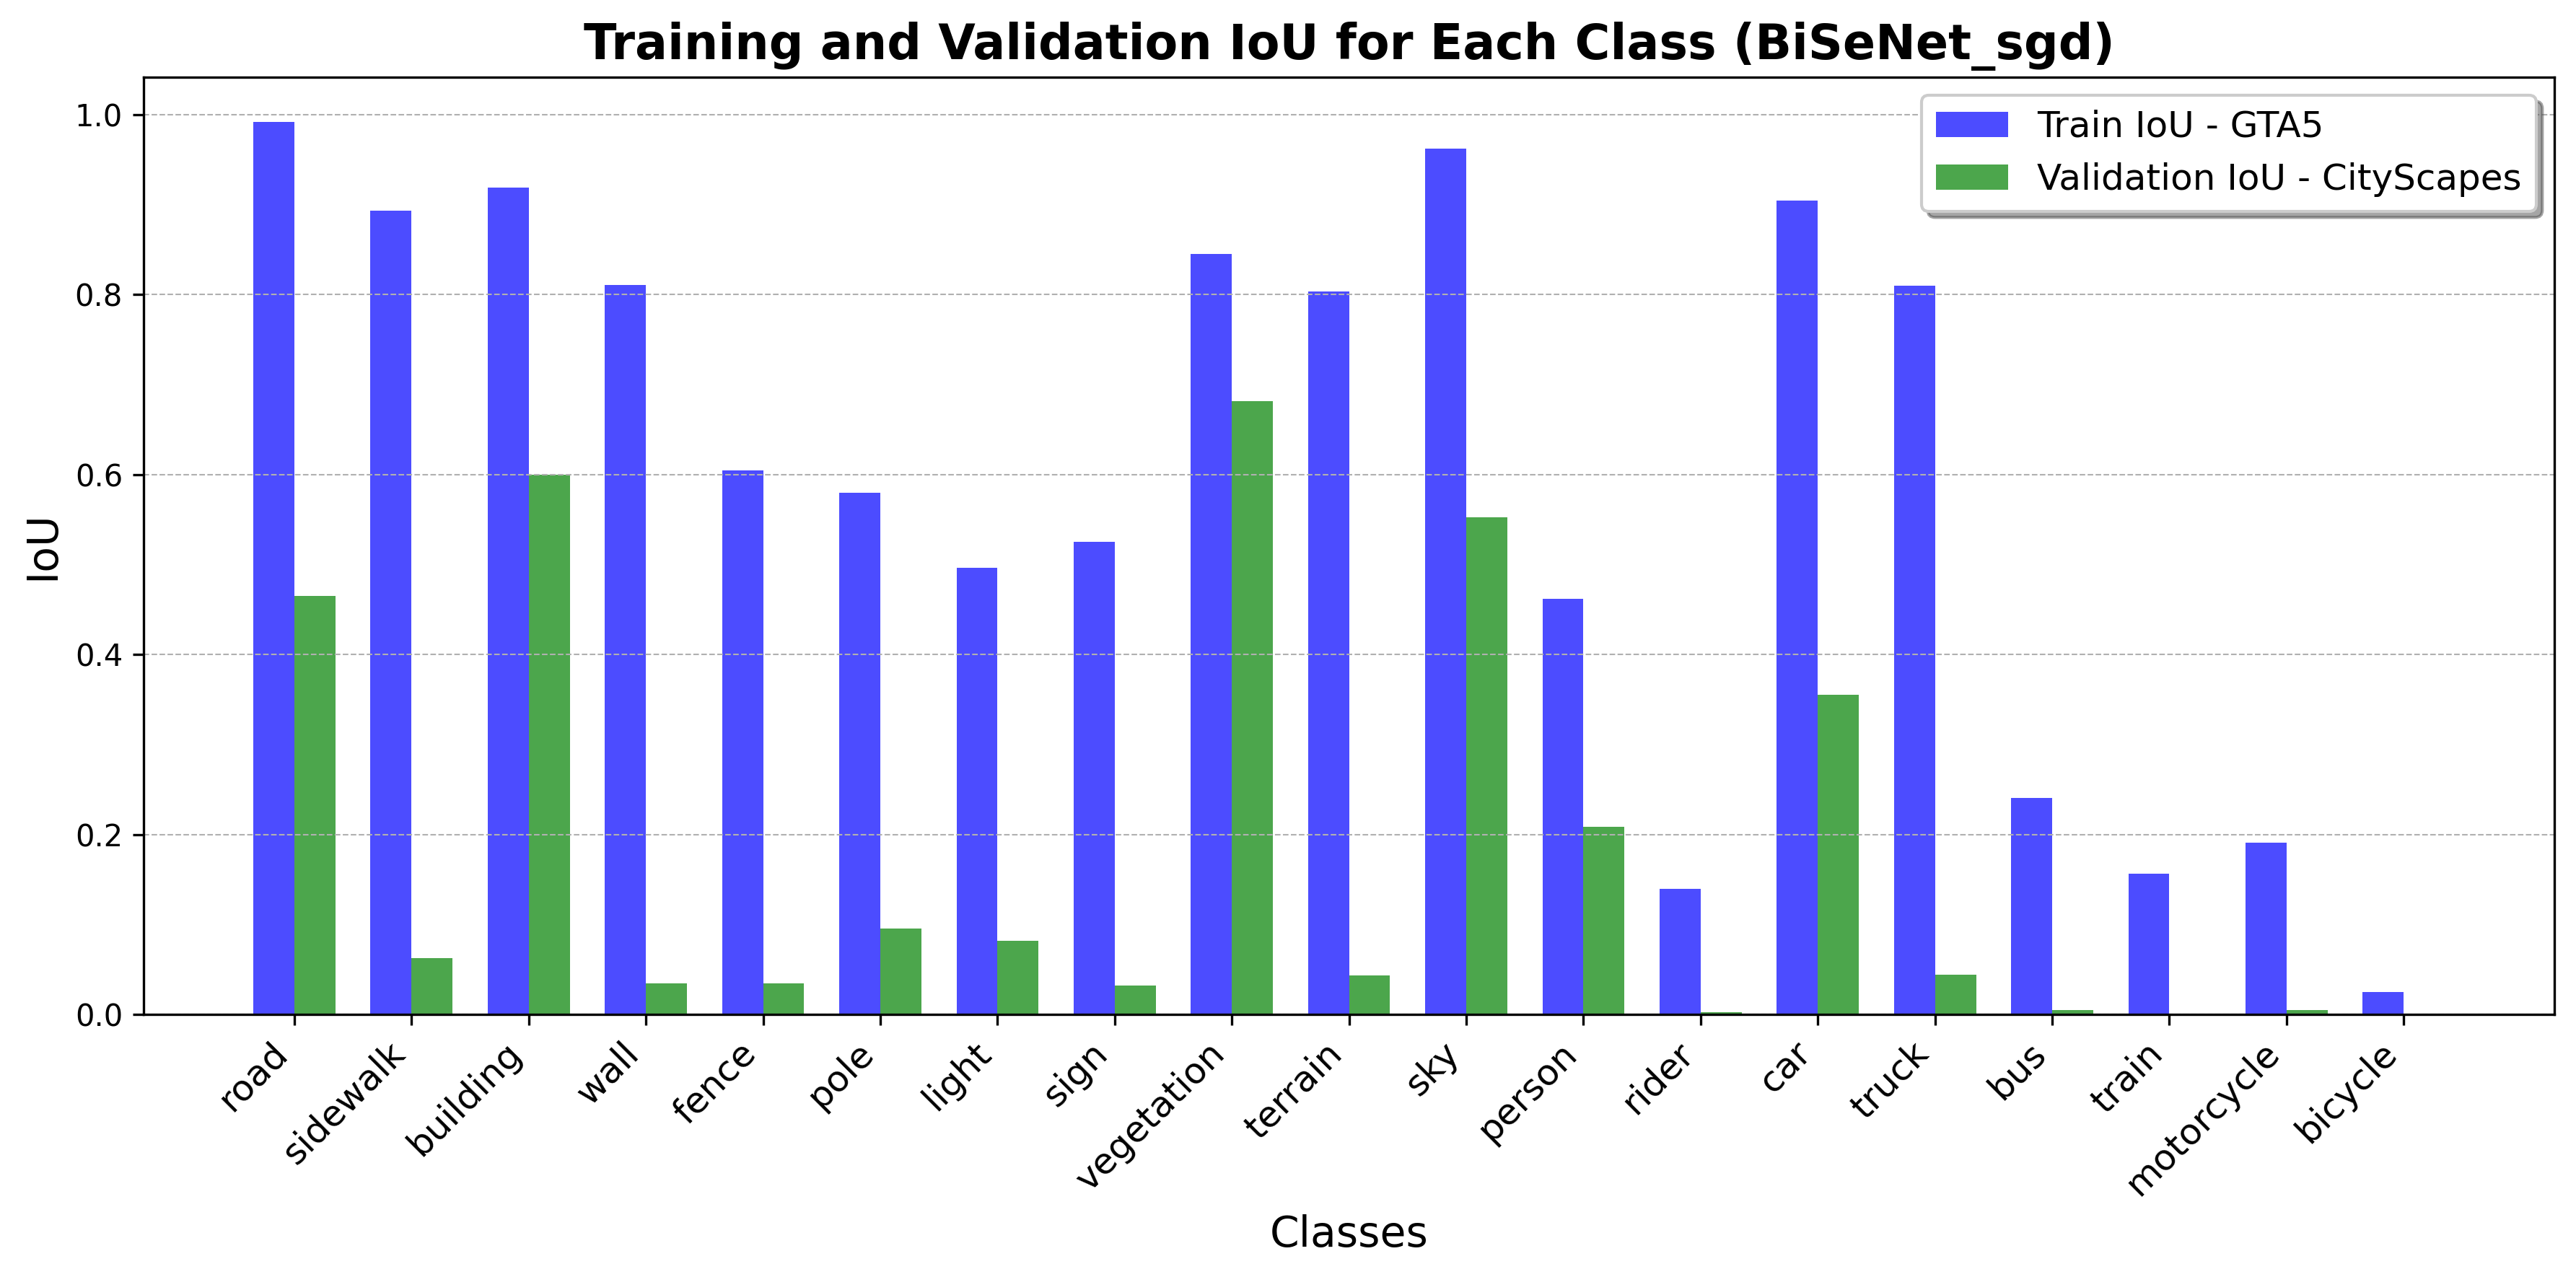

In [6]:
save_results(model_bisenet_3_1, bisenet_result_3_1, "bisenet_sgd_performance_metrics_3_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=1000, device=device)
plot_loss(bisenet_result_3_1, "BiSeNet_sgd", "step3_1", "GTA5", "CityScapes")
plot_mIoU(bisenet_result_3_1, "BiSeNet_sgd", "step3_1", "GTA5", "CityScapes")
plot_IoU(bisenet_result_3_1, "BiSeNet_sgd", "step3_1", "GTA5", "CityScapes")
torch.save(model_bisenet_3_1.state_dict(), "./checkpoints/bisenet_model_3_1.pth")

## 3.2 Bisenet with augmentation



In [4]:
init_lr = 2.5e-2

augmentations = {
    # 'transform1': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.HorizontalFlip(p=0.5),
    #     A.ColorJitter(p=0.5),

    # ]),
    # 'transform2': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.ColorJitter(p=0.5),
    #     A.GaussianBlur(p=0.5),

    # ]),
    'transform3': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(p=0.5),
    ]),
    # 'transform4': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.ColorJitter(p=0.5),
    #     A.GaussianBlur(p=0.5),
    #     A.GaussNoise(p=0.5),

    # ]),
}
best_score = 0
best_transform = ''

# Evaluate each augmentation strategy
for transform_name, transform_pipeline in augmentations.items():
    # Prepare datasets with the current transformation
    cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transform_pipeline)
    cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transform_pipeline)
    GTA5_dataset = GTA5('./GTA5', transform=transform_pipeline)

    # Create dataloaders
    cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize model and optimizer
    model_bisenet_3_2 = BiSeNet(19, 'resnet18').to(device)
    if device == 'cuda' and torch.cuda.device_count() > 1:
        model_bisenet_3_2 = torch.nn.DataParallel(model_bisenet_3_2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.SGD(model_bisenet_3_2.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)

    # Train the model
    bisenet_result3_2 = train(model=model_bisenet_3_2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              train_dataloader=GTA5_dataloader,
                              validation_dataloader=cityscapes_test_dataloader,
                              epochs=EPOCHS,
                              device=device,
                              model_name="bisenet",
                              class_number=NC)
    
    # Save and plot results
    save_results(model_bisenet_3_2, bisenet_result3_2, f"bisenet_sgd_performance_metrics_3_2_{transform_name}", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
    plot_loss(bisenet_result3_2, "BiSeNet", f"step3_2_sgd_{transform_name}", "GTA5", "CityScapes")
    plot_mIoU(bisenet_result3_2, "BiSeNet", f"step3_2_sgd_{transform_name}", "GTA5", "CityScapes")
    plot_IoU(bisenet_result3_2, "BiSeNet", f"step3_2_sgd_{transform_name}", "GTA5", "CityScapes")
    
    # Save model checkpoint
    torch.save(model_bisenet_3_2.state_dict(), f"./checkpoints/bisenet_sgd_model_3_2_{transform_name}.pth")
    
    # Update best performing transformation
    if best_score < bisenet_result3_2[3][-1]:
        best_score = bisenet_result3_2[3][-1]
        best_transform = transform_name

best_transform


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.8130663069725037, Validation Loss: 1.4436123638153076
Train mIoU: 0.2298000379825706, Validation mIoU: 0.14342518743057878
Epoch: 1
Train Loss: 1.1225865949630738, Validation Loss: 1.6547423887252808
Train mIoU: 0.297832886387774, Validation mIoU: 0.12292566255693779
Epoch: 2
Train Loss: 0.9331044722557068, Validation Loss: 2.4064587593078612
Train mIoU: 0.33167659389772136, Validation mIoU: 0.1006815922002365
Epoch: 3
Train Loss: 0.816114631319046, Validation Loss: 1.9683424406051635
Train mIoU: 0.3617369703153731, Validation mIoU: 0.12880139833675833
Epoch: 4
Train Loss: 0.7370922523498535, Validation Loss: 2.704838583946228
Train mIoU: 0.3906581941147489, Validation mIoU: 0.09986927240217906
Epoch: 5
Train Loss: 0.6743182826995849, Validation Loss: 5.083323438644409
Train mIoU: 0.41436278272464305, Validation mIoU: 0.06550034355868457
Epoch: 6
Train Loss: 0.6217746088981628, Validation Loss: 3.003721287727356
Train mIoU: 0.43324989170383826, Validation mIoU: 0

In [ ]:
init_lr = 2.5e-2

augmentations = {
    # 'transform1': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.HorizontalFlip(p=0.5),
    #     A.ColorJitter(p=0.5),

    # ]),
    # 'transform2': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.ColorJitter(p=0.5),
    #     A.GaussianBlur(p=0.5),

    # ]),
    'transform5': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
    ]),
    # 'transform4': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.ColorJitter(p=0.5),
    #     A.GaussianBlur(p=0.5),
    #     A.GaussNoise(p=0.5),

    # ]),
}
best_score = 0
best_transform = ''

# Evaluate each augmentation strategy
for transform_name, transform_pipeline in augmentations.items():
    # Prepare datasets with the current transformation
    cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transform_pipeline)
    cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transform_pipeline)
    GTA5_dataset = GTA5('./GTA5', transform=transform_pipeline)

    # Create dataloaders
    cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize model and optimizer
    model_bisenet_3_2 = BiSeNet(19, 'resnet18').to(device)
    if device == 'cuda' and torch.cuda.device_count() > 1:
        model_bisenet_3_2 = torch.nn.DataParallel(model_bisenet_3_2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.SGD(model_bisenet_3_2.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)

    # Train the model
    bisenet_result3_2 = train(model=model_bisenet_3_2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              train_dataloader=GTA5_dataloader,
                              validation_dataloader=cityscapes_test_dataloader,
                              epochs=EPOCHS,
                              device=device,
                              model_name="bisenet",
                              class_number=NC)
    
    # Save and plot results
    save_results(model_bisenet_3_2, bisenet_result3_2, f"bisenet_sgd_performance_metrics_3_2_{transform_name}", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
    plot_loss(bisenet_result3_2, "BiSeNet", f"step3_2_sgd_{transform_name}", "GTA5", "CityScapes")
    plot_mIoU(bisenet_result3_2, "BiSeNet", f"step3_2_sgd_{transform_name}", "GTA5", "CityScapes")
    plot_IoU(bisenet_result3_2, "BiSeNet", f"step3_2_sgd_{transform_name}", "GTA5", "CityScapes")
    
    # Save model checkpoint
    torch.save(model_bisenet_3_2.state_dict(), f"./checkpoints/bisenet_sgd_model_3_2_{transform_name}.pth")
    
    # Update best performing transformation
    if best_score < bisenet_result3_2[3][-1]:
        best_score = bisenet_result3_2[3][-1]
        best_transform = transform_name

best_transform


# 4.1 FDA

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.998139367198944, Validation Loss: 1.0388561725616454
Train mIoU: 0.22430030284453792, Validation mIoU: 0.18516450465941114
Epoch: 1
Train Loss: 1.2610715962409973, Validation Loss: 0.7349399342536926
Train mIoU: 0.28561161133309626, Validation mIoU: 0.21249193944843633
Epoch: 2
Train Loss: 1.088827407836914, Validation Loss: 1.212659948348999
Train mIoU: 0.3169667311360961, Validation mIoU: 0.18116122819921218
Epoch: 3
Train Loss: 0.981042701625824, Validation Loss: 1.0994973330497742
Train mIoU: 0.3421599610334552, Validation mIoU: 0.19553505726186296
Epoch: 4
Train Loss: 0.8816450067520142, Validation Loss: 0.9165010380744935
Train mIoU: 0.36622534540979784, Validation mIoU: 0.22910742656768804
Epoch: 5
Train Loss: 0.8011551699638366, Validation Loss: 0.73677183842659
Train mIoU: 0.3872270628104433, Validation mIoU: 0.24908423975773364
Epoch: 6
Train Loss: 0.7435573964595795, Validation Loss: 0.9373207931518555
Train mIoU: 0.40569627734177294, Validation mIoU: 

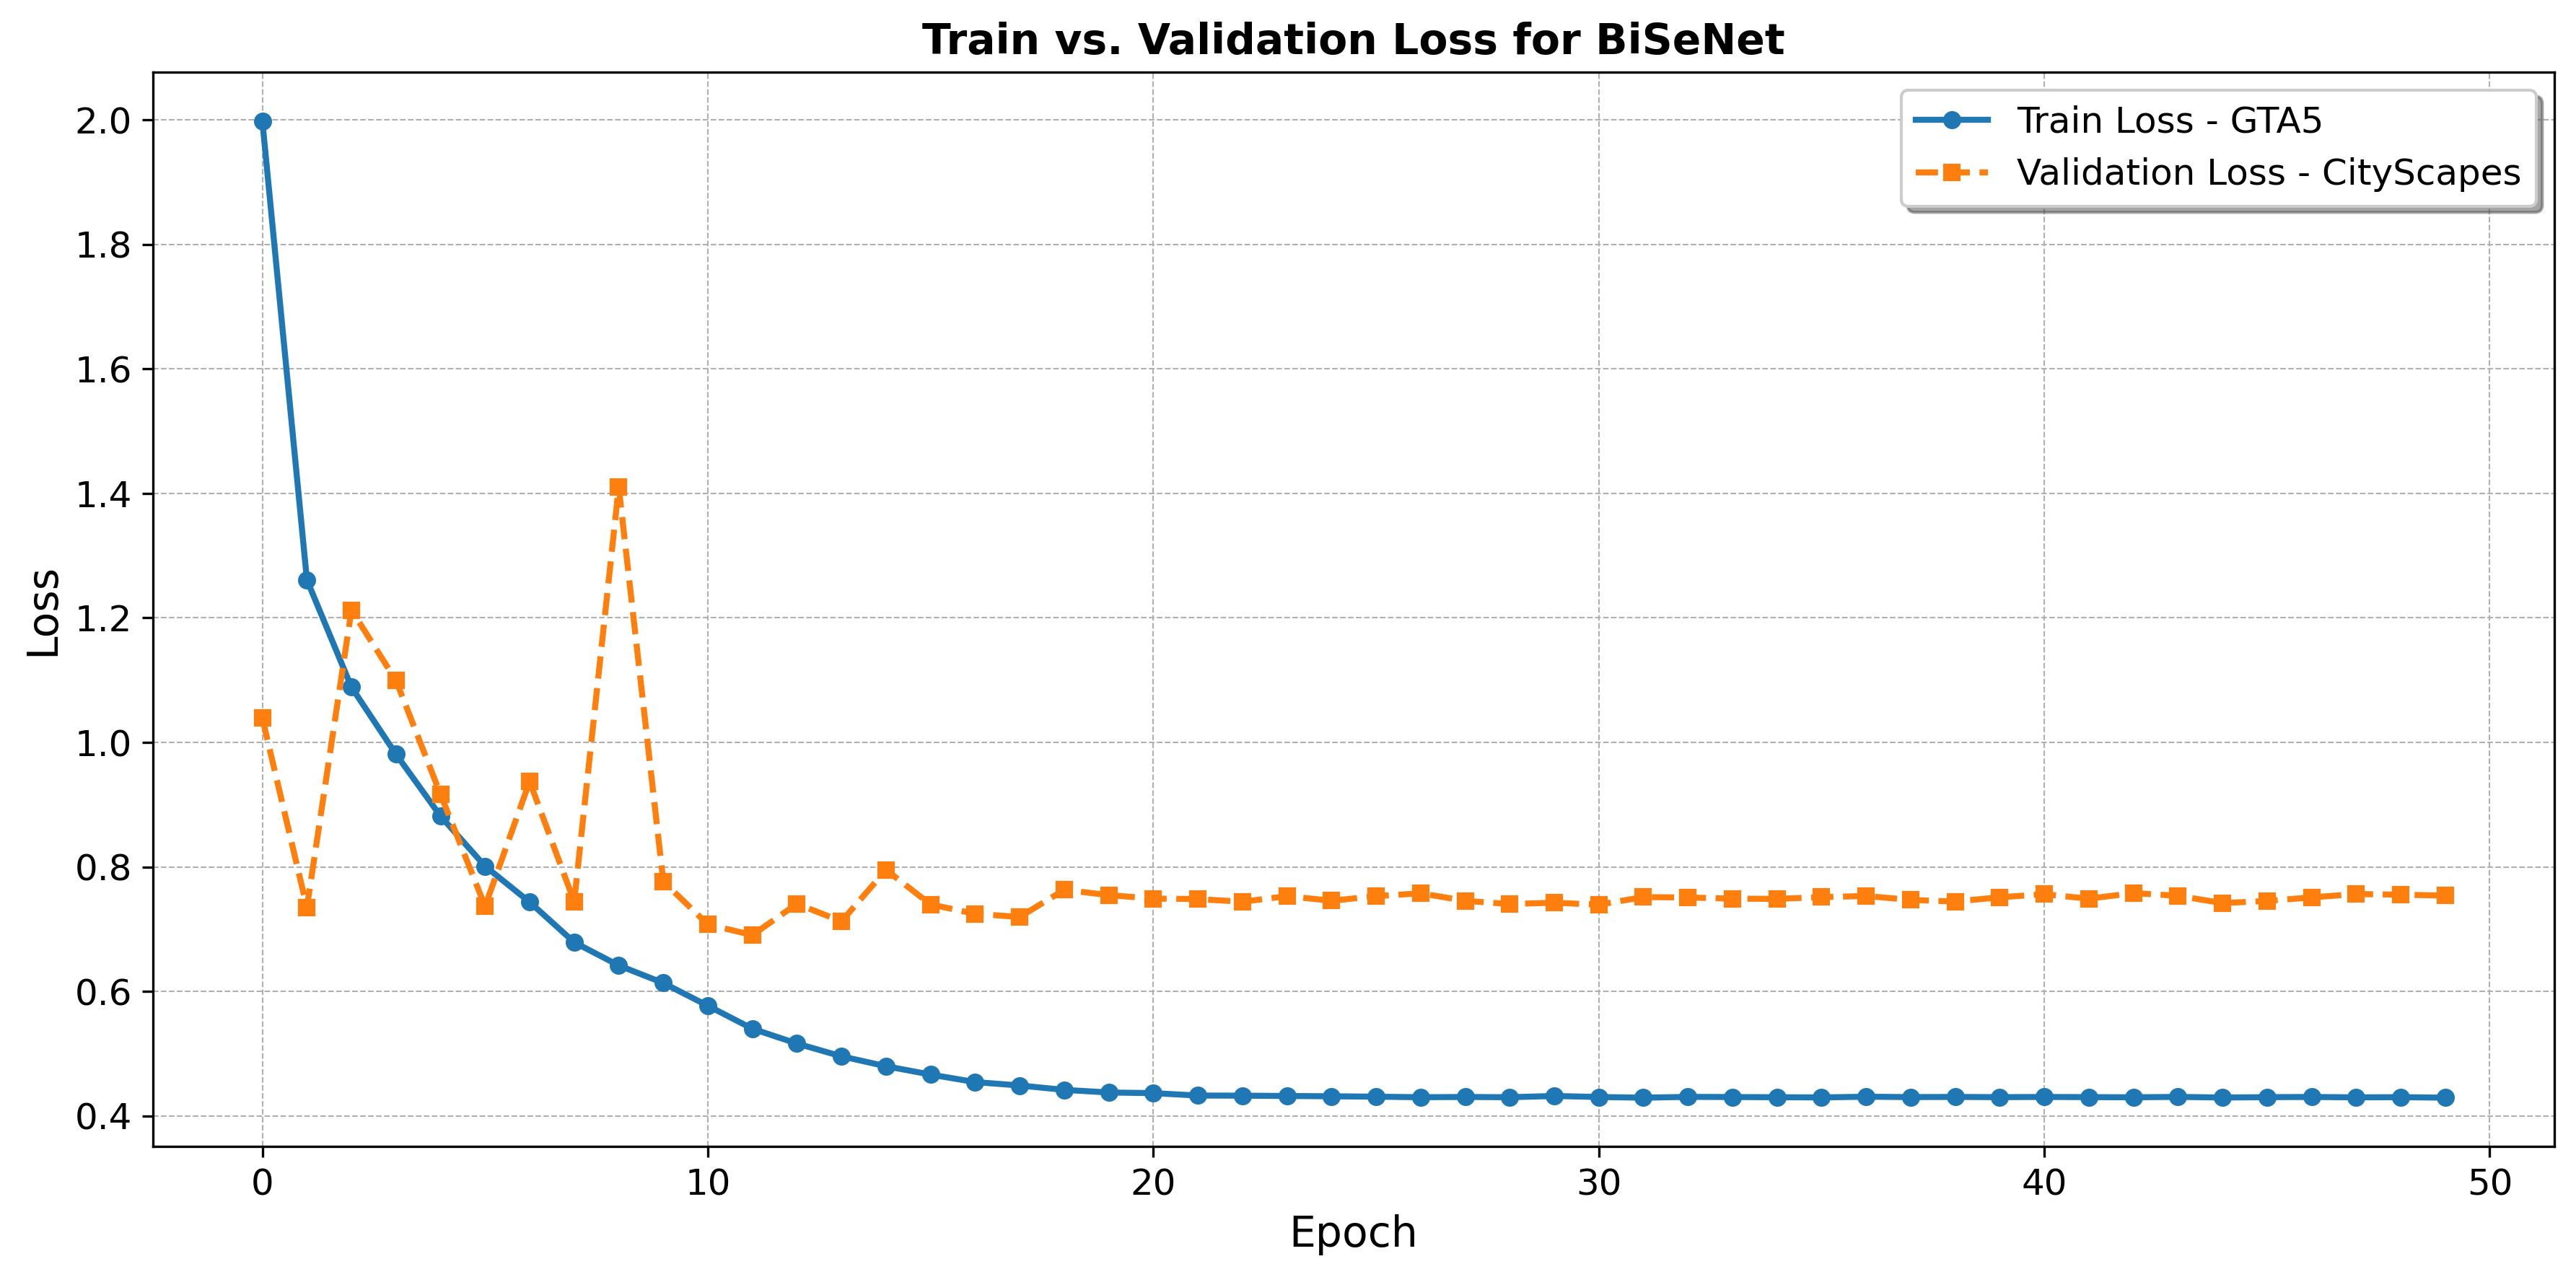

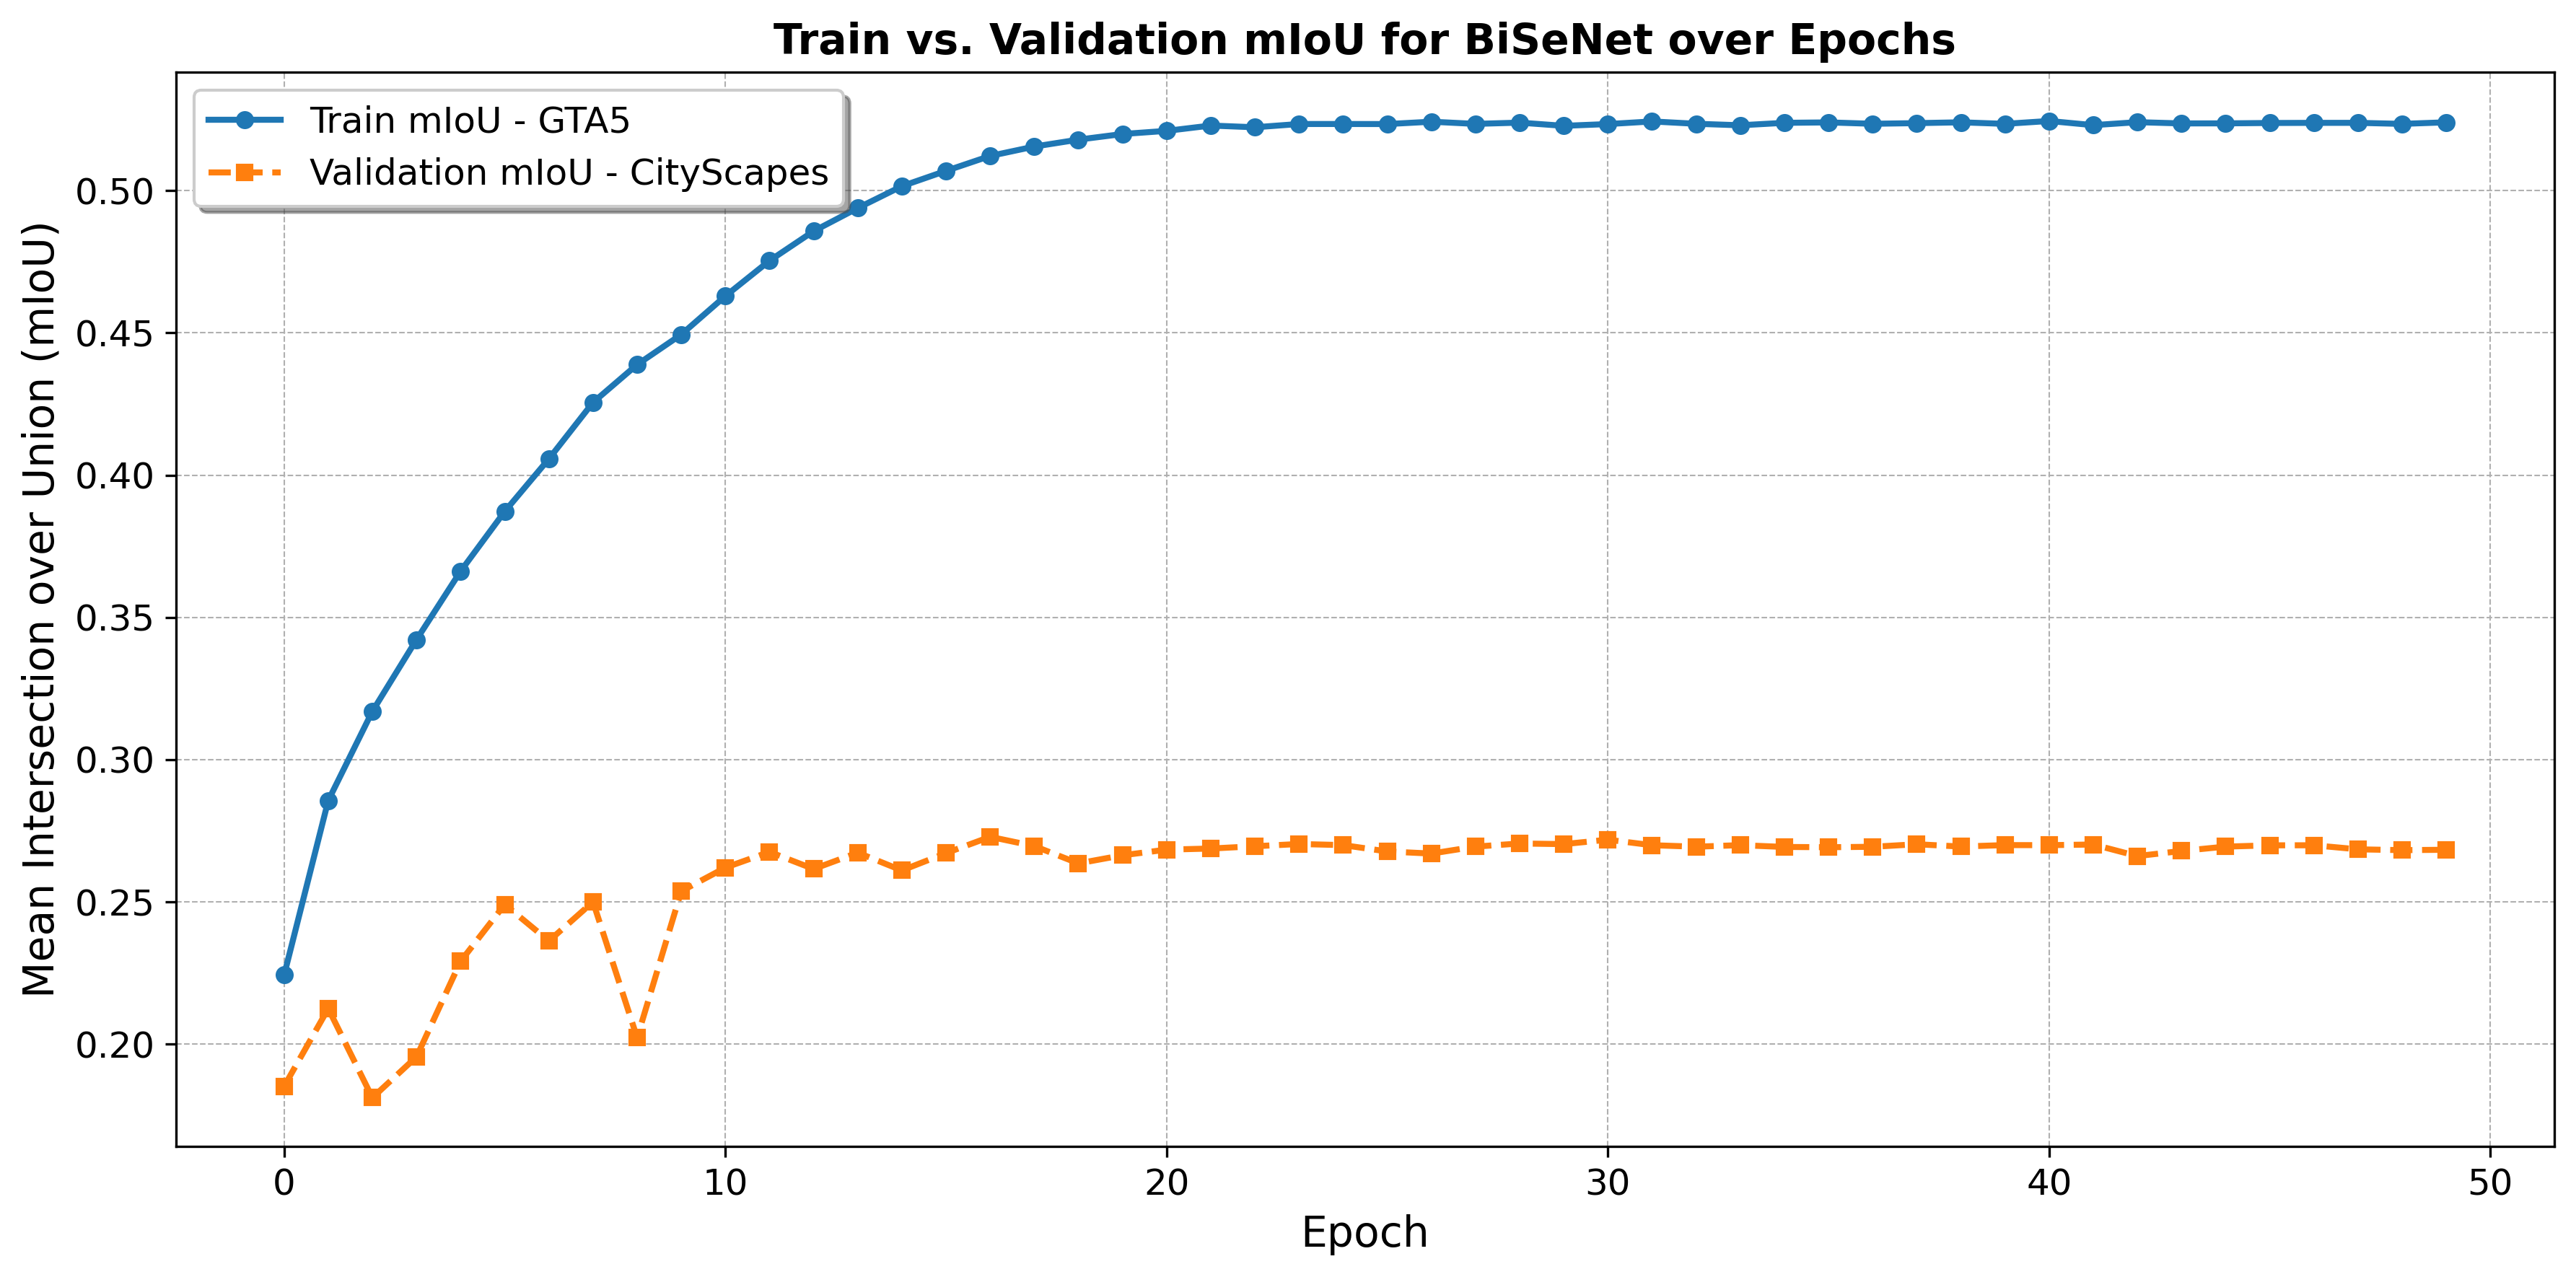

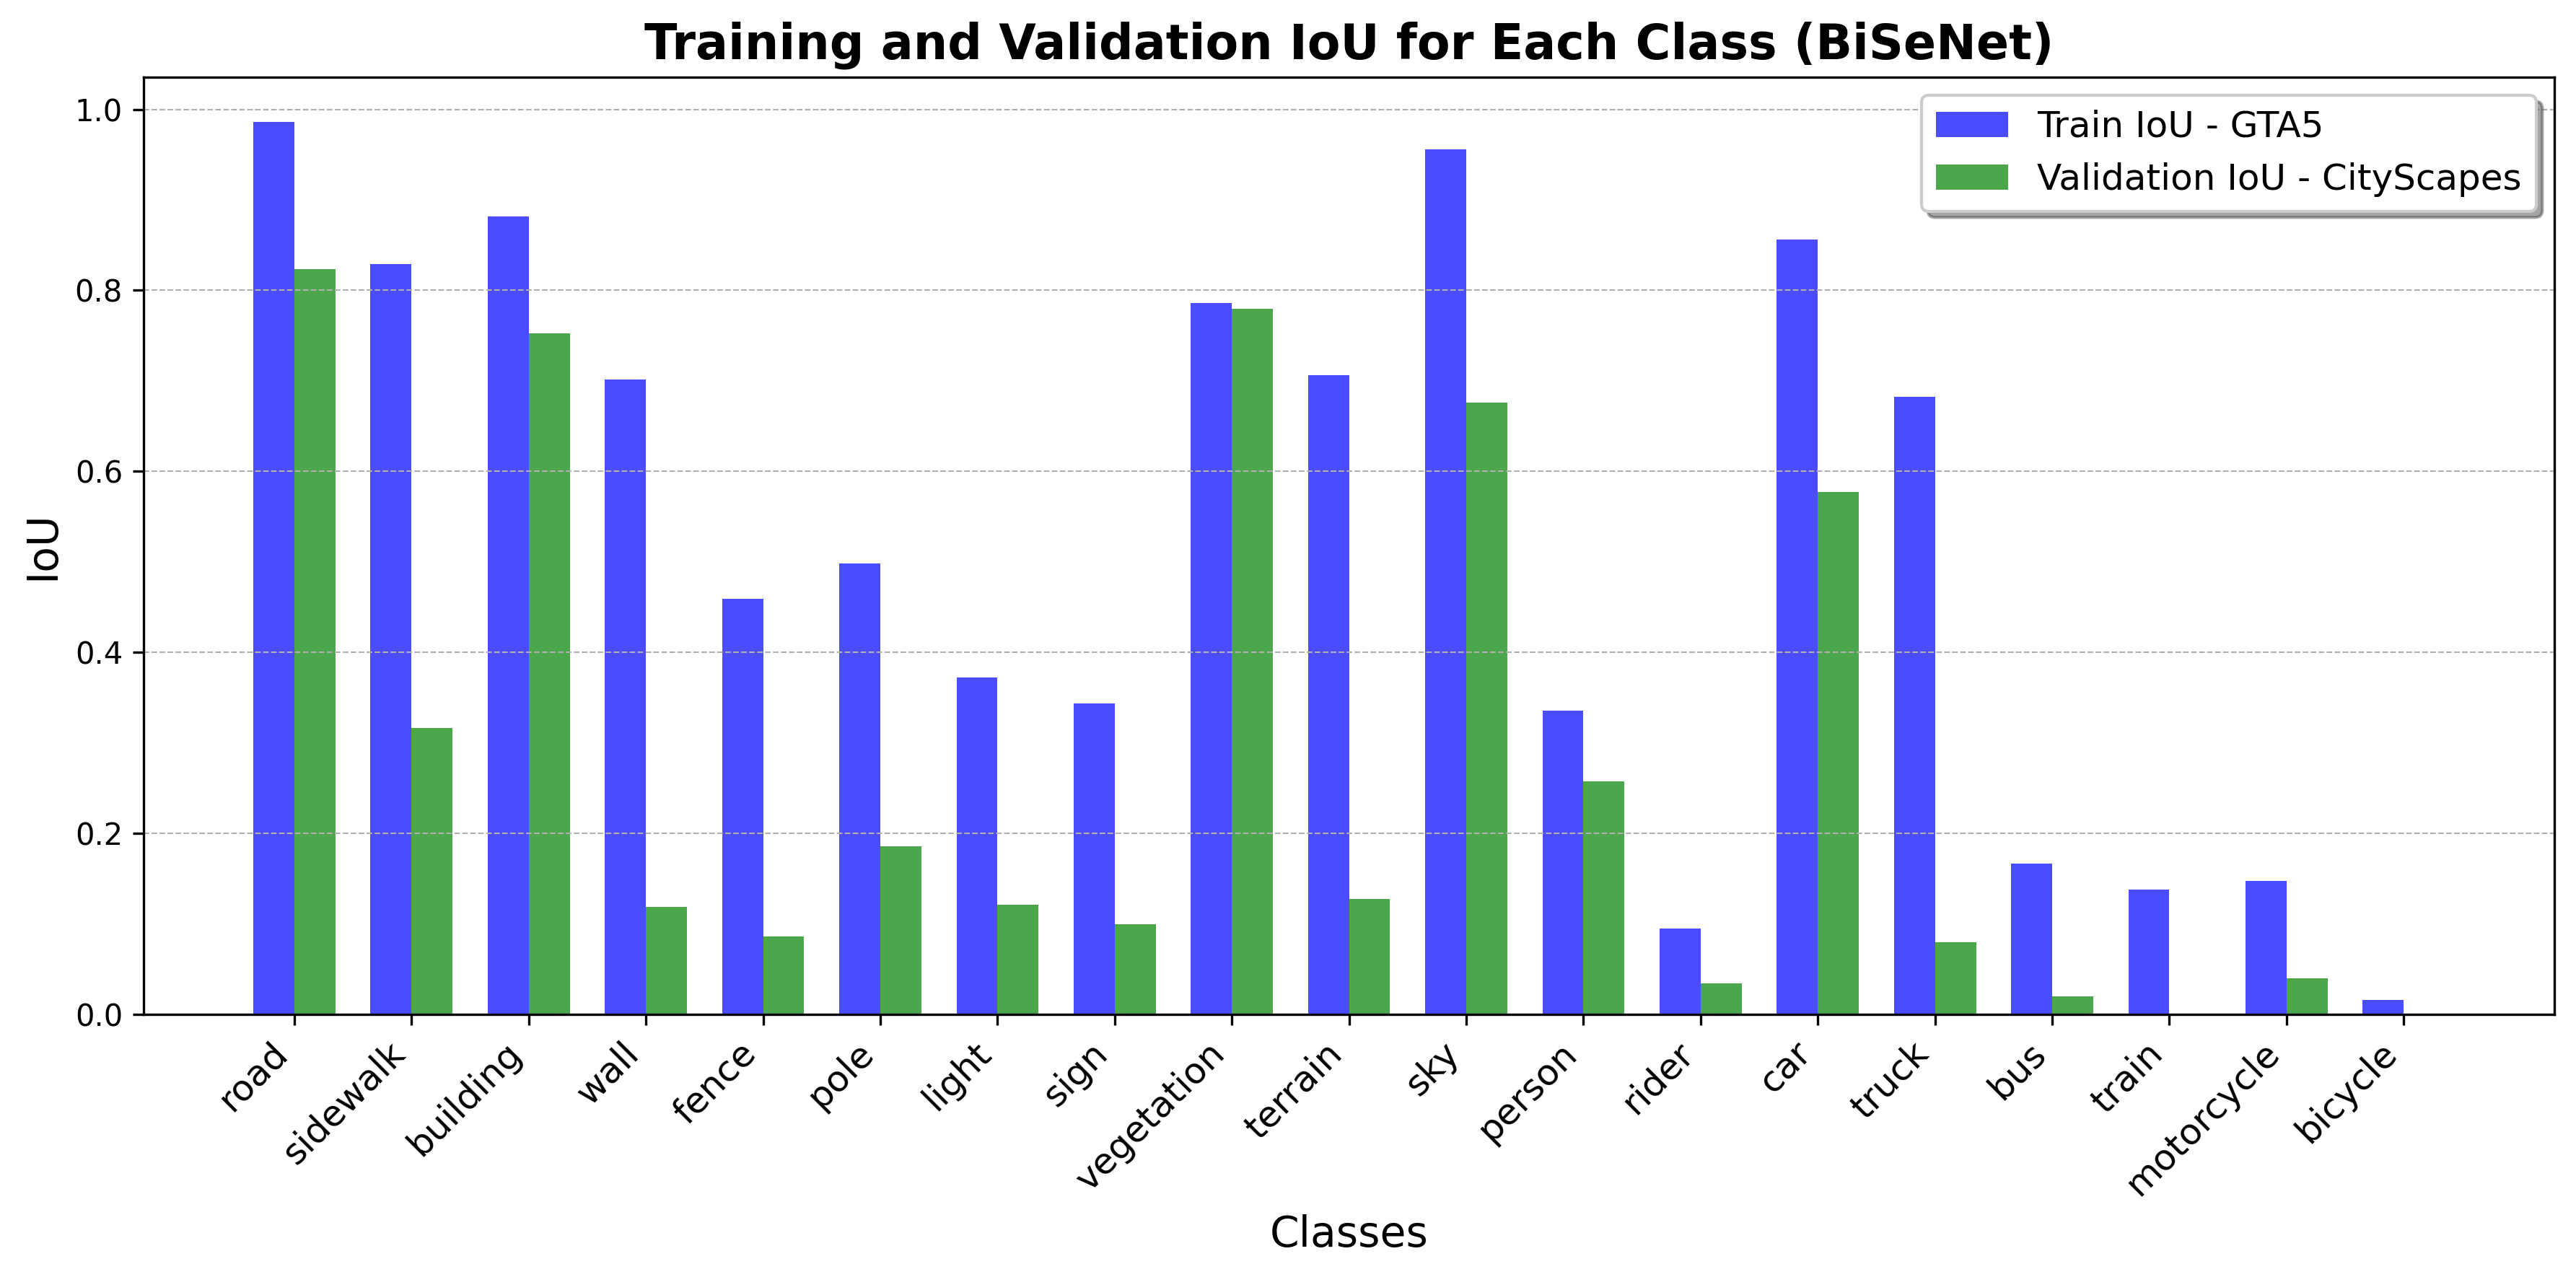

In [ ]:
augmentations = {
    'transform1': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.5),

    ]),
    'transform2': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),

    ]),
    'transform3': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(p=0.5),
    ]),
    'transform4': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),

    ]),
}
GTA5_dataset = GTA5('./GTA5', transform=augmentations['transform2'], FDA = 0.09)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model_bisenet_4_1_FDA = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_1_FDA = torch.nn.DataParallel(model_bisenet_4_1_FDA).to(device)
init_lr = 7.5e-4 #0.0001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(model_bisenet_4_1_FDA.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)

bisenet_result4_1_FDA = train(model = model_bisenet_4_1_FDA,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              train_dataloader = GTA5_dataloader,
                              validation_dataloader = cityscapes_test_dataloader,
                              epochs = EPOCHS,
                              device = device,
                              model_name = "bisenet",
                              class_number= NC)

    
save_results(model_bisenet_4_1_FDA, bisenet_result4_1_FDA, "bisenet_sgd_performance_metrics_4_1_FDA", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(bisenet_result4_1_FDA, "BiSeNet", "step4_1_sgd_FDA", "GTA5", "CityScapes")
plot_mIoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_sgd_FDA", "GTA5", "CityScapes")
plot_IoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_sgd_FDA", "GTA5", "CityScapes")
torch.save(model_bisenet_4_1_FDA.state_dict(), f"./checkpoints/bisenet_sgd_model_4_1_FDA.pth")


# 4.2 DACS

1- In the paper they say that they are using pretrained model. but in pseudocode they say that they are initializing the model with random parameters.


In [3]:

# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best], FDA = 0.09)
GTA5_dataset = GTA5('./GTA5', transform=augmentations['transform2'])
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=2, shuffle=False, num_workers=NUM_WORKERS)
sigma = 150 # 175 for gta5 size, 100 for cityscapes size
# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best_transform], FDA = 0.09)

# GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
model_bisenet_4_2_DACS = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_2_DACS = torch.nn.DataParallel(model_bisenet_4_2_DACS).to(device)
init_lr = 7.5e-4 #0.0001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(model_bisenet_4_2_DACS.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)

bisenet_result4_2_DACS = train(model = model_bisenet_4_2_DACS,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               train_dataloader= GTA5_dataloader,
                               validation_dataloader=cityscapes_test_dataloader,
                               target_dataloader=cityscapes_train_dataloader,
                               epochs=EPOCHS,
                               device = device,
                               model_name='bisenet',
                               )
save_results(model_bisenet_4_2_DACS, bisenet_result4_2_DACS, "bisenet_sgd_performance_metrics_4_2_DACS", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(bisenet_result4_2_DACS, "BiSeNet_sgd", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_mIoU(bisenet_result4_2_DACS, "BiSeNet_sgd", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_IoU(bisenet_result4_2_DACS, "BiSeNet_sgd", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")

torch.save(model_bisenet_4_2_DACS.state_dict(), "./checkpoints/bisenet_sgd_model_4_2_DACS.pth")


  0%|          | 0/50 [00:00<?, ?it/s]

Processing image 0.0952, ----- 100.73849558830261
Processing image 0.1912, ----- 98.710688829422
Processing image 0.2872, ----- 96.87806820869446
Processing image 0.3832, ----- 97.22541856765747
Processing image 0.4792, ----- 96.86898565292358
Processing image 0.5752, ----- 97.50241708755493
Processing image 0.6712, ----- 97.39197444915771
Processing image 0.7672, ----- 97.40290951728821
Processing image 0.8632, ----- 97.09679293632507
Processing image 0.9592, ----- 97.51171469688416
Epoch: 0
Train Loss: 1.9749563189983368, Validation Loss: 0.9288646593093872
Train mIoU: 0.16610978497608977, Validation mIoU: 0.1763398766775094
Processing image 0.0952, ----- 97.13113212585449
Processing image 0.1912, ----- 96.41470670700073
Processing image 0.2872, ----- 96.4125394821167
Processing image 0.3832, ----- 96.72899341583252
Processing image 0.4792, ----- 97.77489829063416
Processing image 0.5752, ----- 96.99521350860596
Processing image 0.6712, ----- 96.62357068061829
Processing image 0.7672

KeyboardInterrupt: 